# gpu/cpu check

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
tf.test.gpu_device_name()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 722209078358496138
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14465892352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15424144674672197605
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **GOOGLE drive upload**

In [ ]:
from google.colab import files
uploaded = files.upload()

# Import library

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, MeanIoU
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import CustomObjectScope,normalize
from tensorflow.keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import random, math ,cv2
from PIL import Image
from glob import glob
from tqdm import tqdm
from skimage import io
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt

# **Create Dataset and metrics**

In [3]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
# shuffle input data
def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_data(img_dir, msk_dir, split=0.1):
    images = sorted(glob(os.path.join(img_dir, "*.jpg")))
    masks = sorted(glob(os.path.join(msk_dir, "*.png")))

    test_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=test_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=test_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)  ## (H, W, 3) as RGB img, no. of channel : 3
    x = cv2.resize(x, (W, H))               ## resizing
    x = x/255.0                             ## normalize, int -> float : decrease converting time
    x = x.astype(np.float32)             
    return x                                ## (256, 256, 3)

def read_image_hair_removal(path):
    path = path.decode()
    src = cv2.imread(path, cv2.IMREAD_COLOR)  ## (H, W, 3) as RGB img, no. of channel : 3
    src = cv2.resize(src, (W, H))             ## resizing
    # convert to grayscale
    grayScale = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(1, (17,17))  # Kernel for the morphological filtering
    # Perform the blackHat filtering on the grayscale image to find the 
    # hair countours
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    # intensify the hair countours in preparation for the inpainting 
    # algorithm
    ret,thresh2 = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    # inpaint the original image depending on the mask
    dst = cv2.inpaint(src, thresh2, 1, cv2.INPAINT_TELEA)
    x = dst/255.0                             ## normalize, int -> float : decrease converting time
    x = x.astype(np.float32)             
    return x  

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (H, W) as grayscale, no. of channel : 0
    x = cv2.resize(x, (W, H))                   ## resizing
    x = x/255.0                                 ## normalize, int -> float : decrease converting time
    x = x.astype(np.float32)                    ## (256, 256)
    x = np.expand_dims(x, axis=-1)              ## (256, 256, 1), -1 means at last position
    return x

def tf_parse(x, y):
    def _parse(x, y):
        # # without hair removal
        # x = read_image(x)
        # y = read_mask(y)

        # with hair removal
        x = read_image_hair_removal(x)
        y = read_mask(y)
        return x, y
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset
    
def get_validation_result(csv_path):
    df = pd.read_csv(csv_path)
    mean_acc = df['Acc'].mean()
    mean_f1 = df['F1'].mean()
    mean_j = df['Jaccard'].mean()
    mean_recall = df['Recall'].mean()
    mean_pre = df['Precision'].mean()
    print('Accuracy:',mean_acc,'\n','F1:',mean_f1,'\n','Jaccard:',mean_j,'\n','Recall:',mean_recall,'\n','Precision:',mean_pre)

# **Build U-net**

In [4]:
H, W = 256, 256
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

"""Loss function"""
def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jaccard_coef_loss(y_true, y_pred):
    return -jaccard_coef(y_true, y_pred)

"""Convolutional block"""
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # added BatchNormalization and Activation 'relu' between 2 Conv2D layers
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

"""Encoder"""
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)  ## Convolution process will increase the depth of the image
    p = MaxPool2D((2, 2))(x)             ## Maxpooling halves down size of image
    return x, p

"""Decoder"""
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])  
    x = conv_block(x, num_filters)
    return x

"""U-net definition"""
def build_unet(input_shape):
    inputs = Input(input_shape)      
        
    """ Encoder: Down sampling """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    """ Bridge : The bottom Layer """
    b1 = conv_block(p4, 1024)

    """ Decoder : Up sampling """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Outputs : binary segmentation use sigmoid """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    """ Model """
    model = Model(inputs, outputs)
    return model

"""ResNet50-Unet"""
def build_resnet50_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = resnet50.get_layer(index=0).output             ## (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model

# **Data set size check**

In [ ]:
img_path = '/content/drive/MyDrive/ISIC2018/Dataset/t1_train_images/'
msk_path = '/content/drive/MyDrive/ISIC2018/Dataset/t1_train_masks/'
val_img_path = '/content/drive/MyDrive/ISIC2018/Dataset/t1_val_images/'
val_msk_path = '/content/drive/MyDrive/ISIC2018/Dataset/t1_val_masks/'

train_images = glob(os.path.join(img_path,'train_t12', "*.jpg"))
train_masks = glob(os.path.join(msk_path,'train_t1_gt', "*.png"))
val_images = glob(os.path.join(val_img_path,'val_t12', "*.jpg"))
val_masks = glob(os.path.join(val_msk_path, 'val_t1_gt',"*.png"))

2594 2594 100 100


In [ ]:
print('\tTrain images:',len(train_images),'\n','\tTrain masks:',len(train_masks),'\n', '\tValidation images:',len(val_images),'\n','\tValidation masks:',len(val_masks))

	Train images: 2594 
 	Train masks: 2594 
 	Validation images: 100 
 	Validation masks: 100


#**Main function - Loading the model**

In [ ]:
%cd /content/drive/MyDrive/ISIC2018/Models/ResNet50_Unet_v2

/content/drive/MyDrive/ISIC2018/Models/ResNet50_Unet_v2


In [ ]:
model_path = '/content/drive/MyDrive/ISIC2018/Models/Unet(origin)/u-net-model.h5'
with CustomObjectScope({'dice_loss' : dice_loss,'dice_coef': dice_coef}):
    model = tf.keras.models.load_model(model_path) 

In [ ]:
model.summary()

In [ ]:
table=pd.DataFrame(columns=["Name","Type","Shape"])
for layer in model.layers:
    table = table.append({"Name":layer.name, "Type": layer.__class__.__name__,"Shape":layer.output_shape}, ignore_index=True)
table.to_csv('./u-net_structure.csv')

In [ ]:
%cd /content/drive/MyDrive/ISIC2018/Models/u_net_with_hair_removal
%load_ext tensorboard
%tensorboard --logdir logs/

#**Model training**

In [ ]:
%cd /content/drive/MyDrive/ISIC2018/Models/u_net_with_hair_removal
#save_dir = '/content/drive/MyDrive/ISIC2018/Models/ResNet50_Unet_v2'
save_dir = './'

"""2018 dataset"""
train_images = '/content/drive/MyDrive/ISIC2018/Dataset/t1_train_images/train_t12'
train_masks = '/content/drive/MyDrive/ISIC2018/Dataset/t1_train_masks/train_t1_gt'

if __name__ == "__main__":
    """ Seeding : make result reproducible"""
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Folder for saving data """
    create_dir(save_dir)

    # """ Hyperparameters """
    # batch_size = 4
    # lr = 1e-4
    # num_epoch = 10
    # H,W = 256,256 

    """ Hyperparameters_v2 (2022-03-06)"""
    batch_size = 8
    lr = 1e-5
    num_epoch = 15
    H,W = 256,256 

    """output dir"""
    model_path = f"{save_dir}/u_net_hr.h5"
    csv_path = f"{save_dir}/u_net_hr.csv"   

    """Load dataset"""
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(train_images,train_masks)
    train_dataset = tf_dataset(train_x, train_y, batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch_size)
    test_dataset = tf_dataset(test_x, test_y, batch_size)

    """step size"""
    train_steps = len(train_x)//batch_size
    valid_steps = len(valid_x)//batch_size

    """do not forget about the reamainder"""
    if len(train_x) % batch_size != 0:
        train_steps += 1

    if len(valid_x) % batch_size != 0:
        valid_steps += 1

    """Summary"""
    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test: {len(test_x)} - {len(test_y)}")

    # """ Build Model """
    # model = build_resnet50_unet((H, W, 3))

    """reload model"""
    with CustomObjectScope({'dice_loss' : dice_loss,'dice_coef': dice_coef}):
        model = tf.keras.models.load_model(model_path) 

    metrics = [dice_coef, Recall(), Precision(), 'accuracy']
    model.compile(loss=[dice_loss], optimizer=Adam(lr), metrics=metrics)
    callbacks = [
                    ModelCheckpoint(filepath=model_path, verbose=1,save_best_only=True), 
                    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7, verbose=1),
                    CSVLogger(csv_path),
                    TensorBoard(),
                    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
                ]
    """Model.fit without augmentation"""
    history = model.fit(
                            train_dataset,
                            epochs = num_epoch,
                            validation_data = valid_dataset,
                            steps_per_epoch = train_steps,
                            validation_steps = valid_steps,
                            callbacks = callbacks
                        )

/content/drive/MyDrive/ISIC2018/Models/u_net_with_hair_removal
Train: 2076 - 2076
Valid: 259 - 259
Test: 259 - 259
Epoch 1/15
260/260 [==============================] - ETA: 0s - loss: 0.1163 - dice_coef: 0.8837 - recall_1: 0.9771 - precision_1: 0.9615 - accuracy: 0.9861
Epoch 1: val_loss improved from inf to 0.17981, saving model to ./u_net_hr.h5
260/260 [==============================] - 2246s 9s/step - loss: 0.1163 - dice_coef: 0.8837 - recall_1: 0.9771 - precision_1: 0.9615 - accuracy: 0.9861 - val_loss: 0.1798 - val_dice_coef: 0.8184 - val_recall_1: 0.8630 - val_precision_1: 0.8981 - val_accuracy: 0.9434 - lr: 1.0000e-05
Epoch 2/15
260/260 [==============================] - ETA: 0s - loss: 0.1116 - dice_coef: 0.8884 - recall_1: 0.9773 - precision_1: 0.9628 - accuracy: 0.9865
Epoch 2: val_loss improved from 0.17981 to 0.17558, saving model to ./u_net_hr.h5
260/260 [==============================] - 777s 3s/step - loss: 0.1116 - dice_coef: 0.8884 - recall_1: 0.9773 - precision_1: 0.

In [ ]:
%cd /content/drive/MyDrive/ISIC2018/Models/u_net_with_hair_removal
%load_ext tensorboard
%tensorboard --logdir logs/

# **Model Validation**

In [ ]:
%cd /content/drive/MyDrive/ISIC2018/Models/Unet(jaccard)

/content/drive/MyDrive/ISIC2018/Models/Unet(jaccard)


In [ ]:
img_path = '/content/drive/MyDrive/ISIC2018/Dataset/t1_val_images/val_t12'
msk_path = '/content/drive/MyDrive/ISIC2018/Dataset/t1_val_masks/val_t1_gt'
root_path = '/content/drive/MyDrive/ISIC2018/Models/Unet(jaccard)'
output_dir = 'Validation_result'
model_name = 'Jaccard_Unet_v1.h5'
H = 256
W = 256

def load_validation_dataset(img_path, msk_path):
    images = sorted(glob(os.path.join(img_path, "*.jpg")))
    masks = sorted(glob(os.path.join(msk_path, "*.png")))
    test_x = images
    test_y = masks
    return (test_x, test_y)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)  ## (H, W, 3)
    x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    return ori_x, x                         ## (1, 256, 256, 3)
    
def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (H, W)
    x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)                    ## (256, 256)
    return ori_x, x

def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)  ## (256, 256, 1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1) ## (256, 256, 3)

    y_pred = np.expand_dims(y_pred, axis=-1)  ## (256, 256, 1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) ## (256, 256, 3)

    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred*255], axis=1)
    cv2.imwrite(save_image_path, cat_images)

def evaluation():
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Folder for saving results """
    create_dir(output_dir)

    """ Load the model """
    model = tf.keras.models.load_model(f"{root_path}/{model_name}",compile=False)

    """ Load the test data """
    (test_x, test_y) = load_validation_dataset(img_path, msk_path)

    """init score list"""
    SCORE = []

    """save result images to path"""
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        """ Exctracting the image name """
        name = x.split("/")[-1]

        """ Read the image and mask """
        ori_x, x = read_image(x)
        ori_y, y = read_mask(y)

        """ Predicting the mask """
        y_pred = model.predict_generator(x)[0] > 0.5
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred.astype(np.int32)

        """ Saving the predicted mask """
        save_dir = f"{root_path}/{output_dir}"
        save_image_path = f"{save_dir}/{name}"
        save_results(ori_x, ori_y, y_pred, save_image_path)

        """ Flatten the array """                                               
        y = y.flatten()
        y_pred = y_pred.flatten()

        """ Calculating metrics values """
        acc_value = accuracy_score(y, y_pred)
        f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")                     # for binary targets
        jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")               # suffixes apply as with ‘f1’
        recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")             # suffixes apply as with ‘f1’
        precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")       # suffixes apply as with ‘f1’
        SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

    """ print mean metrics values """
    score = [s[1:] for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"Accuracy: {score[0]:0.5f}")
    print(f"F1: {score[1]:0.5f}") # dice_coef = 2*F1
    print(f"Jaccard: {score[2]:0.5f}") #IoU
    print(f"Recall: {score[3]:0.5f}")
    print(f"Precision: {score[4]:0.5f}")

    """save csv file"""
    df = pd.DataFrame(SCORE, columns = ["Image Name", "Acc", "F1", "Jaccard", "Recall", "Precision"])
    csv_dir = output_dir
    csv_name = 'validation_score.csv'
    df.to_csv(f"{csv_dir}/{csv_name}")

In [ ]:
evaluation()

In [ ]:
csv_path = '/content/drive/MyDrive/ISIC2018/Models/ResNet50_Unet_v2/Validation_result/validation_score_v2.csv'
get_validation_result(csv_path)

Accuracy: 0.9329776000976563 
 F1: 0.8729624669575626 
 Jaccard: 0.7931092477678118 
 Recall: 0.9058861328261092 
 Precision: 0.8706600815223419


# **Test model**


In [ ]:
%cd /content/drive/MyDrive/ISIC2018/Models/u_net_with_hair_removal

H,W = 256,256
predict_ds = '/content/drive/MyDrive/ISIC2018/Dataset/t1_test_images/test_t12'
predict_dir = './Prediction_result'
model_path = './u_net_hr.h5'

def load_test_dataset(dataset_path):
    images = sorted(glob(os.path.join(dataset_path, predict_ds, "*.jpg")))
    return images

def read_test_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)  ## (H, W, 3)
    x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    return ori_x, x                         ## (1, 256, 256, 3)

def save_results(ori_x, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255

    y_pred = np.expand_dims(y_pred, axis=-1)  ## (256, 256, 1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) ## (256, 256, 3)

    cat_images = np.concatenate([ori_x, line, y_pred*255], axis=1)
    cv2.imwrite(save_image_path, cat_images)

def prediction():
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Folder for saving results """
    #create_dir(predict_dir)

    """ Load the model """
    with CustomObjectScope({'dice_loss' : dice_loss,'dice_coef': dice_coef}):
        model = tf.keras.models.load_model(model_path) 

    """ Load the test data """
    # dataset_path = "/content/drive/MyDrive/ISIC2018/"
    test_x = load_test_dataset(predict_ds)
    SCORE = []
    for x in tqdm(test_x,total=len(test_x)):
        """ Exctracting the image name """
        name = x.split("/")[-1]

        """ Read the image and mask """
        ori_x, x = read_test_image(x)

        """ Predicting the mask """
        y_pred = model.predict(x)[0] > 0.5
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred.astype(np.int32)

        """ Saving the predicted mask """
        save_image_path = f"./Prediction_result/{name}"
        save_results(ori_x, y_pred, save_image_path)

        # """ Flatten the array """                                               
        # y_pred = y_pred.flatten()

        # """ Calculating metrics values """
        # acc_value = accuracy_score(y, y_pred)
        # f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")                     # for binary targets
        # jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")               # suffixes apply as with ‘f1’
        # recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")             # suffixes apply as with ‘f1’
        # precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")       # suffixes apply as with ‘f1’
        # SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

/content/drive/MyDrive/ISIC2018/Models/u_net_with_hair_removal


In [ ]:
prediction()

100%|██████████| 1000/1000 [04:01<00:00,  4.14it/s]


# **Create np data set**

In [ ]:
%cd /content/drive/MyDrive/ISIC2018/Dataset/test_images/test_t12
image_directory = '/content/drive/MyDrive/ISIC2018/Dataset/Task2-3/train_t3/'
mask_directory = '/content/drive/MyDrive/ISIC2018/Dataset/val_masks/val_t1_gt/'
test_directory = '/content/drive/MyDrive/ISIC2018/Dataset/test_images/test_t12/'

SIZE = 256
image_dataset = []  
mask_dataset = []  
test_dataset = []

images = sorted(os.listdir(image_directory))
for i, image_name in tqdm(enumerate(images),total=len(images)):
    if (image_name.split('.')[1] == 'jpg'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))
np.save('/content/drive/MyDrive/ISIC2018/Models/image_cache/t3_train_images.npy',image_dataset)

# masks = sorted(os.listdir(mask_directory))
# for i, image_name in tqdm(enumerate(masks),total=len(masks)):
#     if os.path.exists('t1_train_masks.npy'):
#         image_dataset = np.load('t1_train_masks.npy')
#     else:
#         if (image_name.split('.')[1] == 'png'):
#             image = cv2.imread(mask_directory+image_name, 0)
#             image = Image.fromarray(image)
#             image = image.resize((SIZE, SIZE))
#             mask_dataset.append(np.array(image))
# #np.save('/content/drive/MyDrive/ISIC2018/Models/image_cache/t1_val_masks',mask_dataset)

# test = sorted(os.listdir('./'))
# for i, image_name in tqdm(enumerate(test),total=len(test)):    #Remember enumerate method adds a counter and returns the enumerate object
#     if (image_name.split('.')[1] == 'jpg'):
#         #print(image_directory+image_name)
#         image = cv2.imread('./'+image_name)
#         image = Image.fromarray(image)
#         image = image.resize((SIZE, SIZE))
#         test_dataset.append(np.array(image))
# np.save('/content/drive/MyDrive/ISIC2018/Models/image_cache/test_dataset',test_dataset)

# **Test time augmentation**

In [5]:
SIZE = 256

t1_train_image_id = sorted(glob(os.path.join('/content/drive/MyDrive/ISIC2018/Dataset/t1_train_images/train_t12','*.jpg')))
t1_train_mask_id  = sorted(glob(os.path.join('/content/drive/MyDrive/ISIC2018/Dataset/t1_train_masks/train_t1_gt','*.png')))
t1_test_image_id  = sorted(glob(os.path.join('/content/drive/MyDrive/ISIC2018/Dataset/t1_test_images/test_t12','*.jpg')))
t1_val_image_id   = sorted(glob(os.path.join('/content/drive/MyDrive/ISIC2018/Dataset/t1_val_images/val_t12','*.jpg')))
t1_val_mask_id    = sorted(glob(os.path.join('/content/drive/MyDrive/ISIC2018/Dataset/t1_val_masks/val_t1_gt','*.png')))
t3_train_image_id = sorted(glob(os.path.join('/content/drive/MyDrive/ISIC2018/Dataset/t3_train','*.jpg')))
t3_val_image_id   = sorted(glob(os.path.join('/content/drive/MyDrive/ISIC2018/Dataset/t3_val','*.jpg')))
t3_test_image_id  = sorted(glob(os.path.join('/content/drive/MyDrive/ISIC2018/Dataset/t3_test','*.jpg')))

t1_train_image_np = np.load('/content/drive/MyDrive/ISIC2018/Dataset/image_cache/t1_train_images.npy')
t1_train_mask_np  = np.load('/content/drive/MyDrive/ISIC2018/Dataset/image_cache/t1_train_masks.npy')
# t1_test_image_np  = np.load('/content/drive/MyDrive/ISIC2018/Dataset/image_cache/t1_test_images.npy')
t1_val_image_np   = np.load('/content/drive/MyDrive/ISIC2018/Dataset/image_cache/t1_val_images.npy')
t1_val_mask_np    = np.load('/content/drive/MyDrive/ISIC2018/Dataset/image_cache/t1_val_masks.npy')

t1_train_image_ds = (np.array(t1_train_image_np)) / 255.
t1_train_mask_ds  = (np.array(t1_train_mask_np)) / 255.
# t1_test_image_ds  = (np.array(t1_test_image_np)) 
t1_val_image_ds   = (np.array(t1_val_image_np)) / 255.
t1_val_mask_ds    = (np.array(t1_val_mask_np)) / 255.

models = {
  "Res_v1": "/content/drive/MyDrive/ISIC2018/Models/ResNet50_Unet_v1/ResNet50_Unet_v1.h5",
  "Res_v2": "/content/drive/MyDrive/ISIC2018/Models/ResNet50_Unet_v2/ResNet50_Unet_v2.h5",
  "Unet_jaccard": '/content/drive/MyDrive/ISIC2018/Models/Unet(jaccard)/Jaccard_Unet_v1.h5',
  "Unet": "/content/drive/MyDrive/ISIC2018/Models/Unet(origin)/u-net-model.h5",
  "U_fyp":"/content/drive/MyDrive/ISIC2018/Models/Unet_for_fyp_report(origin)/origin_Unet.h5",
  "Unet_hair_removal": "/content/drive/MyDrive/ISIC2018/Models/u_net_with_hair_removal/u_net_hr.h5"
}

In [6]:
print(len(t1_train_image_id),len(t1_test_image_id),len(t1_val_image_id))

2594 1000 100


In [7]:
"""Load model"""
model1 = models["Unet_hair_removal"]
model1 = tf.keras.models.load_model(model1,compile=0) # compile must be false or error prompts

model2 = models["U_fyp"]
model2 = tf.keras.models.load_model(model2,compile=0) # compile must be false or error prompts

model3 = models["Unet"]
model3 = tf.keras.models.load_model(model3,compile=0) # compile must be false or error prompts

model4 = models["Unet_jaccard"]
model4 = tf.keras.models.load_model(model4,compile=0) # compile must be false or error prompts

model5 = models["Res_v1"]
model5 = tf.keras.models.load_model(model5,compile=0) # compile must be false or error prompts

model6 = models["Res_v2"]
model6 = tf.keras.models.load_model(model6,compile=0) # compile must be false or error prompts
"""Load model"""

'Load model'

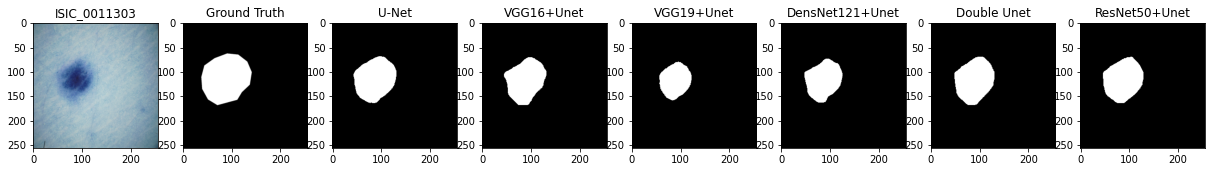

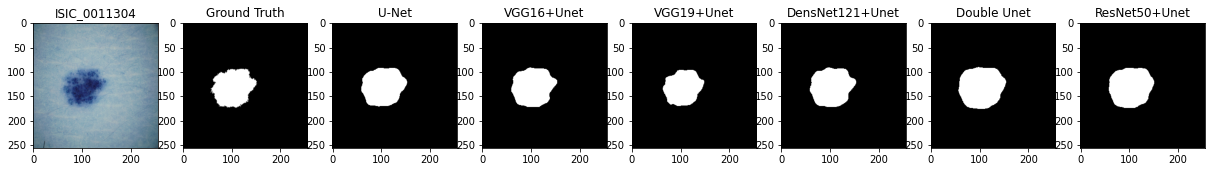

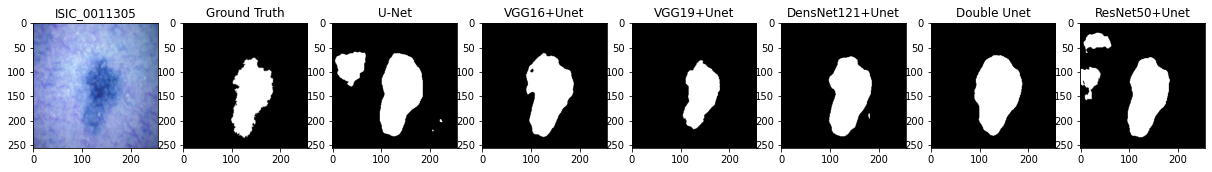

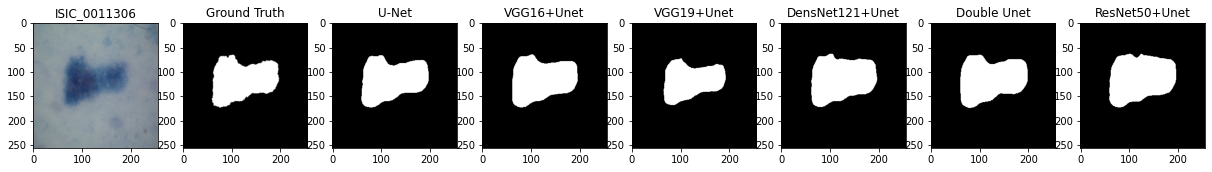

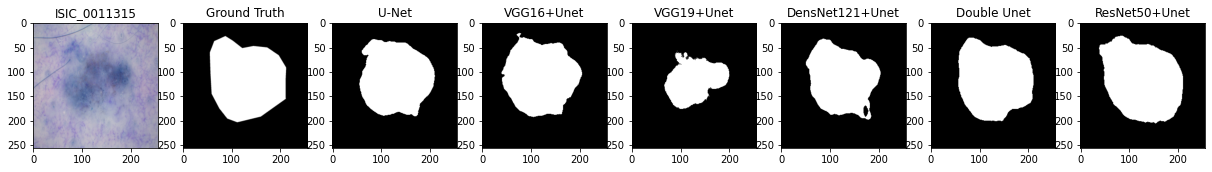

In [9]:
row = 5
n = random.randint(0,len(t1_train_image_id) - row - 1)

for i in range(0,row):
    plt.figure(figsize=(21,35))
    temp_test_img = t1_train_image_ds[n,:,:,:]
    temp_mask = t1_train_mask_ds[n,:,:]
    p1 = model1.predict(np.expand_dims(temp_test_img, axis=0))[0][:, :, 0]
    p2 = model2.predict(np.expand_dims(temp_test_img, axis=0))[0][:, :, 0]
    p3 = model3.predict(np.expand_dims(temp_test_img, axis=0))[0][:, :, 0]
    p4 = model4.predict(np.expand_dims(temp_test_img, axis=0))[0][:, :, 0]
    p5 = model5.predict(np.expand_dims(temp_test_img, axis=0))[0][:, :, 0]
    p6 = model6.predict(np.expand_dims(temp_test_img, axis=0))[0][:, :, 0]

    thresh = 0.9

    """original image"""
    plt.subplot(row,8,1)
    plt.title((t1_train_image_id[n].split('/')[-1]).split('.')[0])
    plt.imshow(temp_test_img)

    plt.subplot(row,8,2)
    plt.title('Ground Truth')
    plt.imshow(temp_mask, cmap='gray')

    plt.subplot(row,8,3)
    plt.title('U-Net')
    plt.imshow(p1>thresh, cmap='gray')

    plt.subplot(row,8,4)
    plt.title('VGG16+Unet')
    plt.imshow(p2>thresh, cmap='gray')

    plt.subplot(row,8,5)
    plt.title('VGG19+Unet')
    plt.imshow(p3>thresh, cmap='gray')

    plt.subplot(row,8,6)
    plt.title('DensNet121+Unet')
    plt.imshow(p4>thresh, cmap='gray')

    plt.subplot(row,8,7)
    plt.title('Double Unet')
    plt.imshow(p5>thresh, cmap='gray')
    
    plt.subplot(row,8,8)
    plt.title('ResNet50+Unet')
    plt.imshow(p6>thresh, cmap='gray')
    n += 1
    plt.show()

#Previous visualization

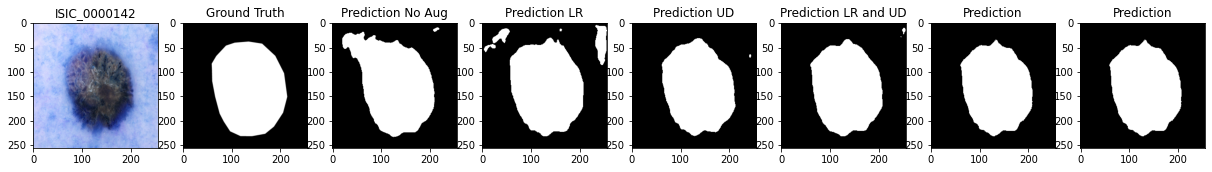

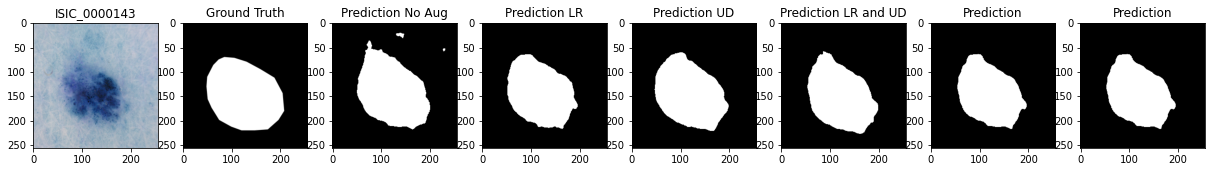

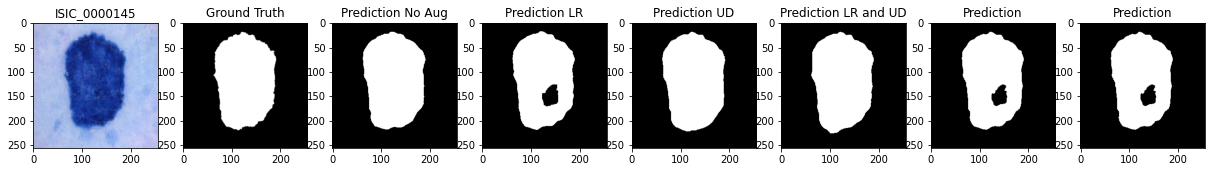

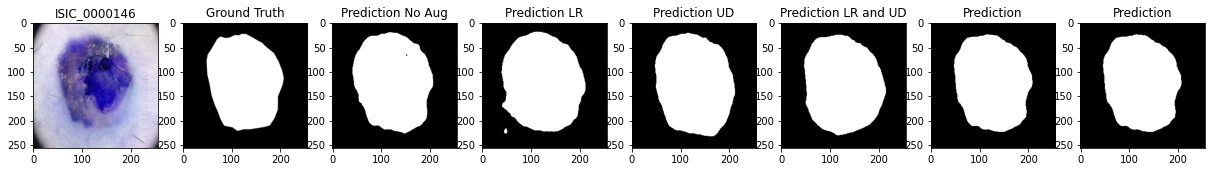

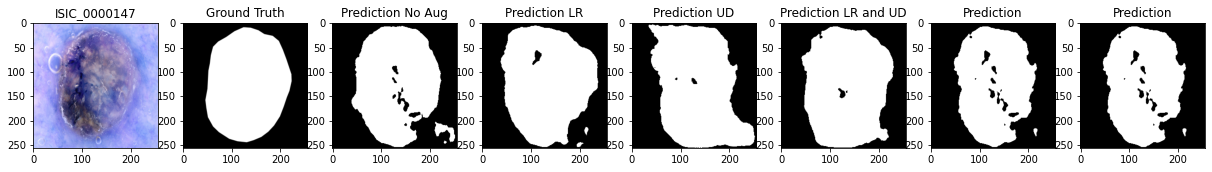

In [ ]:
"""Load model"""
model = models["Unet_hair_removal"]
model = tf.keras.models.load_model(model,compile=0) # compile must be false or error prompts


"""Load model"""

row = 5
n = random.randint(0,len(t1_train_image_id) - row - 1)

for i in range(0,row):
    plt.figure(figsize=(21,35))
    temp_test_img = t1_train_image_ds[n,:,:,:]
    temp_mask = t1_train_mask_ds[n,:,:]
    p0 = model.predict(np.expand_dims(temp_test_img, axis=0))[0][:, :, 0]
    p1 = model.predict(np.expand_dims(np.fliplr(temp_test_img), axis=0))[0][:, :, 0]
    p1 = np.fliplr(p1)
    p2 = model.predict(np.expand_dims(np.flipud(temp_test_img), axis=0))[0][:, :, 0]
    p2 = np.flipud(p2)
    p3 = model.predict(np.expand_dims(np.fliplr(np.flipud(temp_test_img)), axis=0))[0][:, :, 0]
    p3 = np.fliplr(np.flipud(p3))
    thresh = 0.9
    p = (((p0 + p1 + p2 + p3) / 4) > thresh).astype(np.uint8)
    plt.subplot(row,8,1)
    plt.title((t1_train_image_id[n].split('/')[-1]).split('.')[0])
    plt.imshow(temp_test_img)

    plt.subplot(row,8,2)
    plt.title('Ground Truth')
    plt.imshow(temp_mask, cmap='gray')

    plt.subplot(row,8,3)
    plt.title('Prediction No Aug')
    plt.imshow(p0>thresh, cmap='gray')

    plt.subplot(row,8,4)
    plt.title('Prediction LR')
    plt.imshow(p1>thresh, cmap='gray')

    plt.subplot(row,8,5)
    plt.title('Prediction UD')
    plt.imshow(p2>thresh, cmap='gray')

    plt.subplot(row,8,6)
    plt.title('Prediction LR and UD')
    plt.imshow(p3>thresh, cmap='gray')

    plt.subplot(row,8,7)
    plt.title('Prediction')
    plt.imshow(p>thresh, cmap='gray')
    
    plt.subplot(row,8,8)
    plt.title('Prediction')
    plt.imshow(p>thresh, cmap='gray')
    n += 1
    plt.show()